# **Wildfire Prediction Project**

In this project, we will compare the performance of a convolutional neural network and a vision transformer to classify images of wildfire-prone areas of Canada based on their wildfire risk. We will build a small convolutional neural network and vision transformer and tinker with the model hyperparameters to explore which option is better for classification, taking into account the smaller structure and computational efficiency of the vision transformer.

The code for the model is adapted from [this article](https://medium.com/@brianpulfer/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c). Each line of code was written from scratch to aid our understanding of the Vision Transformer architecture.

## **Data Loading:**
Pull data from [Kaggle wildfire prediction dataset](https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset/data) and format into PyTorch tensors. This requires a kaggle account and API key.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from tqdm import tqdm, trange
from PIL import Image
from PIL import ImageFile

np.random.seed(0)
torch.manual_seed(0)

In [2]:
# Removes corrupted image files
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rafaelstankiewicz","key":"2c41ee2f2ac0f6d90c0599006a8818a3"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d abdelghaniaaba/wildfire-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
100% 1.44G/1.45G [00:46<00:00, 37.8MB/s]
100% 1.45G/1.45G [00:46<00:00, 33.3MB/s]


In [ ]:
!unzip wildfire-prediction-dataset.zip

In [7]:
train_path = "../content/train"
valid_path = "../content/test"
test_path = "../content/valid"

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128))
])

train_data = datasets.ImageFolder(train_path, transform=transform)
valid_data = datasets.ImageFolder(valid_path, transform=transform)
test_data = datasets.ImageFolder(test_path, transform=transform)

In [ ]:
image_tensor = train_data[0][0]  # Adjust indexing if needed

print(image_tensor.shape)  # Check the shape of the image tensor
print(image_tensor.min(), image_tensor.max())  # Check the range of values

to_pil = transforms.ToPILImage()
image_pil = to_pil(image_tensor)
image_pil.show()

## **Model Building:**

This is a sketch of the model we're creating!

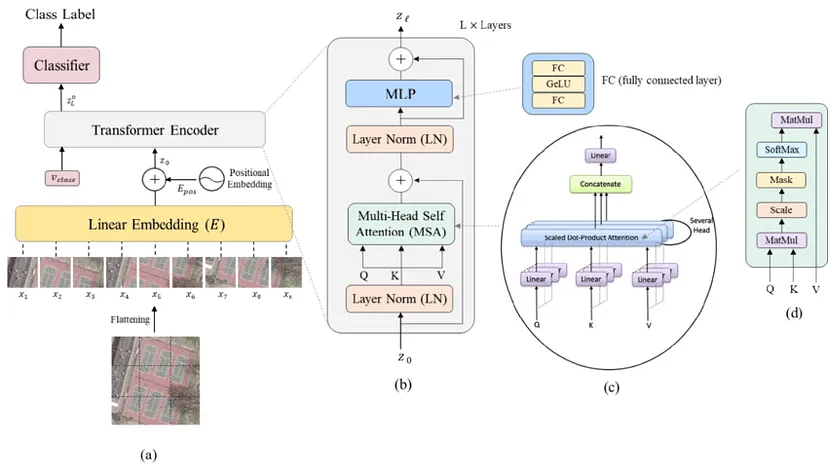

### **Step One: Patchifying**

First, we must squence our data by breaking up images into sub-images and then encoding each sub-image as a vector.

We will reshape into (N, 3, 128, 128) to:

$$(N, P^2, HWC/P^2) = (N, 8 ⋅ 8, 3 \cdot 16 \cdot 16) = (N, 64, 768)$$

We will do so with a patchify() method!

In [10]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w  # Only works for squares images

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for index, image in enumerate(images):
      for i in range(n_patches):
        for j in range(n_patches):
          patch = image[:, i * patch_size: (i+1) * patch_size, j * patch_size: (j + 1) * patch_size]
          patches[index, i * n_patches + j] = patch.flatten()
    return patches

### **Step Two: Linear Embedding, Classification Token, and Positional Embedding**

Classification token and positional embedding steps are implemented further downstream, in step four. However, this was the order I created the model in.

In [11]:
def positional_embeddings(sequence_length, dims):
    result = torch.ones(sequence_length, dims)
    for i in range(sequence_length):
        for j in range(dims):
            result[i][j] = np.sin(i / (10000 ** (j / dims))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / dims)))
    return result

### **Step Three: Encoder**

Create class for multi-head self-attention mechanism and transformer encoder blocks.

In [12]:
class MHSA(nn.Module):
  def __init__(self, dims, n_heads=2):
    super(MHSA, self).__init__()
    self.dims = dims
    self.n_heads = n_heads

    assert dims % n_heads == 0  # Must be able to divide dimension by number of heads

    dim_head = int(dims / n_heads)
    self.query_mappings = nn.ModuleList([nn.Linear(dim_head, dim_head) for _ in range(self.n_heads)])
    self.key_mappings = nn.ModuleList([nn.Linear(dim_head, dim_head) for _ in range(self.n_heads)])
    self.value_mappings = nn.ModuleList([nn.Linear(dim_head, dim_head) for _ in range(self.n_heads)])
    self.dim_head = dim_head
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, sequences):
    # Sequences should have shape (N, seq_length, token_dim)
    # We convert into shape (N, seq_length, n_heads, token_dim / n_heads)
    # And finally return to (N, seq_length, item_dim) via concatenation
    result = []
    for sequence in sequences:
      seq_result = []
      for head in range(self.n_heads):
        query_mapping = self.query_mappings[head]
        key_mapping = self.key_mappings[head]
        value_mapping = self.value_mappings[head]

        seq = sequence[:, head * self.dim_head: (head + 1) * self.dim_head]
        query, key, value = query_mapping(seq), key_mapping(seq), value_mapping(seq)

        attention = self.softmax(torch.matmul(query, key.transpose(0, 1)) / (self.dim_head ** 0.5))
        seq_result.append(torch.matmul(attention, value))
      result.append(torch.hstack(seq_result))
    return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [13]:
class VisionTransformerBlock(nn.Module):
  def __init__(self, hidden_dims, n_heads, mlp_ratio=4):
    super(VisionTransformerBlock, self).__init__()
    self.hidden_dims = hidden_dims
    self.n_heads = n_heads

    self.norm1 = nn.LayerNorm(hidden_dims)
    self.mhsa = MHSA(hidden_dims, n_heads)
    self.norm2 = nn.LayerNorm(hidden_dims)

    # Multi-layer perceptron
    self.mlp = nn.Sequential(
        nn.Linear(hidden_dims, mlp_ratio * hidden_dims),
        nn.GELU(),
        nn.Linear(mlp_ratio * hidden_dims, hidden_dims)
    )

  def forward(self, x):
    output = x + self.mhsa(self.norm1(x))
    output = output + self.mlp(self.norm2(output))
    return output

### **Step Four: Construct Model Class**

In [14]:
class VisionTransformer(nn.Module):
  def __init__(self, chw=(3, 128, 128), n_patches=8, hidden_dims=8, n_blocks=2, n_heads=2, out_dims=2):
    super(VisionTransformer, self).__init__()

    # Model attributes
    self.chw = chw
    self.n_patches = n_patches
    self.hidden_dims = hidden_dims
    self.n_blocks = n_blocks
    self.n_heads = n_heads

    # Input shape should be divisible by number of patches
    assert chw[1] % n_patches == 0
    assert chw[2] % n_patches == 0
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # Linear mapping
    self.input_dims = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_map = nn.Linear(self.input_dims, self.hidden_dims)  # Linear operation only happens on last dim of patch

    # Learnable classification token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_dims))

    # Positional embedding
    self.register_buffer('positional_embeddings', positional_embeddings(n_patches ** 2 + 1, hidden_dims), persistent=False)

    # Transformer encoder blocks
    self.encoder_blocks = nn.ModuleList([VisionTransformerBlock(hidden_dims, n_heads) for _ in range(n_blocks)])

    # Classification layer
    self.final_class = nn.Sequential(
        nn.Linear(self.hidden_dims, out_dims),
        nn.Softmax(dim=-1)
    )

  def forward(self, images):
    # Patchify images
    n, c, h, w = images.shape
    patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

    # Vector embedding
    tokens = self.linear_map(patches)

    # Classification token
    tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

    # Positional embedding
    positional_embedding = self.positional_embeddings.repeat(n, 1, 1)
    output = tokens + positional_embedding

    # Transformer blocks
    for block in self.encoder_blocks:
      output = block(output)

    # Get classification token
    output = output[:, 0]

    return self.final_class(output)  # Map to output dimension

### **Step Five: Instantiate and Train Model**


In [15]:
def plotLoss(train_loss_history, valid_loss_history):
    f, ax = plt.subplots(figsize=(15, 4))
    ax.plot(train_loss_history, label='Training Loss')
    ax.plot(valid_loss_history, label='Validation Loss')
    ax.set_title('Loss Over Training Epochs')
    ax.legend()
    plt.show()

In [16]:
def main():
  # Load data
  train_loader = DataLoader(train_data, shuffle=True, batch_size=128)
  valid_loader = DataLoader(valid_data, shuffle=False, batch_size=128)

  # Define model
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
  model = VisionTransformer(chw=(3, 128, 128), n_patches=8, hidden_dims=8, n_blocks=2, n_heads=2, out_dims=2).to(device)
  num_epochs = 10
  learning_rate = 0.005

  optimizer = Adam(model.parameters(), lr=learning_rate)
  loss_function = CrossEntropyLoss()
  train_losses = []
  valid_losses = []

  # Training model
  for epoch in trange(num_epochs, desc="Training"):
    train_loss = 0.0

    # Training loop
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
      x, y = batch
      x, y = x.to(device), y.to(device)
      y_hat = model(x)
      loss = loss_function(y_hat, y)
      train_loss += loss.detach().cpu().item() / len(train_loader)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_losses.append(train_loss)
    print(f"Epoch {epoch + 1}/{num_epochs} Training loss: {train_loss:.2f}")

    # Evaluation loop
    with torch.no_grad():
      valid_loss = 0.0
      correct, total = 0, 0
      for batch in tqdm(valid_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = loss_function(y_hat, y)
        valid_loss += loss.detach().cpu().item() / len(valid_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)

      valid_losses.append(valid_loss)
      print(f"Valid loss: {valid_loss:.2f}")
      print(f"Valid accuracy: {correct / total * 100:.2f}%")

  plotLoss(train_losses, valid_losses)
  torch.save(model.state_dict(), "/content/ViT.pt")

Using device:  cuda (Tesla T4)


Epoch 1 in training: 100%|██████████| 237/237 [04:50<00:00,  1.03it/s]
                                                                      

Epoch 1/10 Training loss: 0.46



Training:  10%|█         | 1/10 [05:36<50:27, 336.37s/it]

Valid loss: 0.40
Valid accuracy: 90.44%



Epoch 2 in training: 100%|██████████| 237/237 [04:49<00:00,  1.01it/s]
                                                                      

Epoch 2/10 Training loss: 0.42



Training:  20%|██        | 2/10 [11:11<44:44, 335.62s/it]

Valid loss: 0.40
Valid accuracy: 90.38%



Epoch 3 in training: 100%|██████████| 237/237 [04:51<00:00,  1.02it/s]
                                                                      

Epoch 3/10 Training loss: 0.41



Training:  30%|███       | 3/10 [16:49<39:17, 336.73s/it]

Valid loss: 0.39
Valid accuracy: 91.87%



Epoch 4 in training: 100%|██████████| 237/237 [04:54<00:00,  1.02it/s]
                                                                      

Epoch 4/10 Training loss: 0.40



Training:  40%|████      | 4/10 [22:29<33:49, 338.18s/it]

Valid loss: 0.38
Valid accuracy: 92.76%



Epoch 5 in training: 100%|██████████| 237/237 [05:03<00:00,  1.04s/it]
                                                                      

Epoch 5/10 Training loss: 0.40



Training:  50%|█████     | 5/10 [28:18<28:29, 341.95s/it]

Valid loss: 0.38
Valid accuracy: 93.25%



Epoch 6 in training: 100%|██████████| 237/237 [04:52<00:00,  1.06it/s]
                                                                      

Epoch 6/10 Training loss: 0.39



Training:  60%|██████    | 6/10 [33:56<22:42, 340.57s/it]

Valid loss: 0.37
Valid accuracy: 93.79%



Epoch 7 in training: 100%|██████████| 237/237 [04:51<00:00,  1.05it/s]
                                                                      

Epoch 7/10 Training loss: 0.39



Training:  70%|███████   | 7/10 [39:34<16:59, 339.69s/it]

Valid loss: 0.42
Valid accuracy: 88.98%



Epoch 8 in training: 100%|██████████| 237/237 [04:52<00:00,  1.01it/s]
                                                                      

Epoch 8/10 Training loss: 0.39



Training:  80%|████████  | 8/10 [45:13<11:19, 339.59s/it]

Valid loss: 0.38
Valid accuracy: 93.00%



Epoch 9 in training: 100%|██████████| 237/237 [04:51<00:00,  1.04s/it]
                                                                      

Epoch 9/10 Training loss: 0.39



Training:  90%|█████████ | 9/10 [50:49<05:38, 338.47s/it]

Valid loss: 0.39
Valid accuracy: 91.87%



Epoch 10 in training: 100%|██████████| 237/237 [04:52<00:00,  1.05it/s]
                                                                       

Epoch 10/10 Training loss: 0.38



Training: 100%|██████████| 10/10 [56:28<00:00, 338.81s/it]


Valid loss: 0.37
Valid accuracy: 94.49%


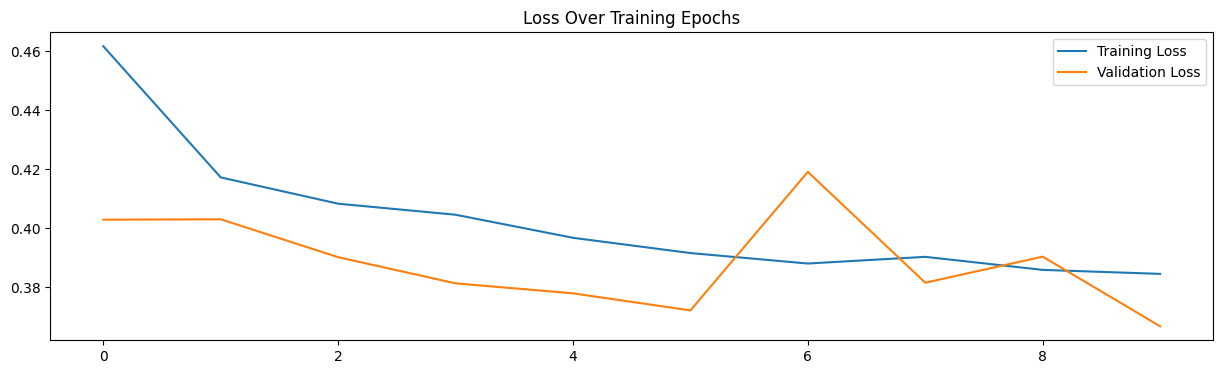

In [17]:
run_model = main()

### **Step Six: Evaluate Model on Test Data**

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
model = VisionTransformer(chw=(3, 128, 128), n_patches=8, hidden_dims=8, n_blocks=2, n_heads=2, out_dims=2).to(device)

model.load_state_dict(torch.load("/content/ViT.pt"))

Using device:  cuda (Tesla T4)


<All keys matched successfully>

In [19]:
test_loader = DataLoader(test_data, shuffle=False, batch_size=128)

model.eval()

loss_function = CrossEntropyLoss()
test_loss_mean = 0
test_correct = 0

with torch.no_grad():
  for test_X, test_Y in test_loader:
    test_X, test_Y = test_X.to(device), test_Y.to(device)
    test_output = model(test_X)
    test_loss = loss_function(test_output, test_Y)

    num_in_batch = len(test_X)
    tloss = test_loss.item() * num_in_batch / len(test_loader.dataset)
    test_loss_mean += tloss

    predictions = test_output.argmax(1)
    test_correct += (predictions == test_Y).type(torch.float).sum().item()

test_accuracy = 100 * (test_correct / len(test_loader.dataset))

print(f"Test Loss = {test_loss_mean:.4f}")
print(f"Test Accuracy = {(test_accuracy):>0.1f}%")

Test Loss = 0.3748
Test Accuracy = 93.5%


In [21]:
!pip install torchsummary
from torchsummary import summary

model_summary = summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 64, 8]           6,152
         LayerNorm-2                [-1, 65, 8]              16
            Linear-3                    [-1, 4]              20
            Linear-4                    [-1, 4]              20
            Linear-5                    [-1, 4]              20
           Softmax-6                   [-1, 65]               0
            Linear-7                    [-1, 4]              20
            Linear-8                    [-1, 4]              20
            Linear-9                    [-1, 4]              20
          Softmax-10                   [-1, 65]               0
           Linear-11                    [-1, 4]              20
           Linear-12                    [-1, 4]              20
           Linear-13                    [-1, 4]              20
          Softmax-14                   